# Analytical Case-Study
### We work for the online store Ice, which sells video games all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources. We need to identify patterns that determine whether a game succeeds or not. This will allow you to spot potential big winners and plan advertising campaigns. We will go through this process in this case-study.

In [72]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats as st
from scipy.stats import levene
import math
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

# Step 1

In [73]:
#import datasets
try:
    game_raw = pd.read_csv('/datasets/games.csv')
except:
    print("Some error")
else:
    print("No exception, everything good")

No exception, everything good


In [74]:
#sample dataset
game_raw.sample(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
4182,Super Momotarou Dentetsu DX,SNES,1995.0,Misc,0.00,0.00,0.47,0.00,NaN,NaN,NaN
9168,Cabela's African Safari,X360,2006.0,Sports,0.13,0.00,0.00,0.01,53.0,5,T
6857,Bakugan: Battle Brawlers,X360,2009.0,Action,0.20,0.02,0.00,0.02,60.0,5.2,E
1143,Dragon Quest IV: Chapters of the Chosen,DS,2007.0,Role-Playing,0.30,0.02,1.27,0.03,80.0,7.9,E10+
11846,SpongeBob's Truth or Square,X360,2009.0,Action,0.03,0.04,0.00,0.00,NaN,6.5,E


In [75]:
#Statistical Description
game_raw.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [76]:
#Data type and len check
game_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [77]:
#Estimate the proportion of missing values in each column
(game_raw.isnull().sum() / game_raw.shape[0] * 100).round(2)

Name                0.01
Platform            0.00
Year_of_Release     1.61
Genre               0.01
NA_sales            0.00
EU_sales            0.00
JP_sales            0.00
Other_sales         0.00
Critic_Score       51.32
User_Score         40.09
Rating             40.48
dtype: float64

In [78]:
#check duplicated rows
game_raw.duplicated().sum()

0

In [79]:
#Check Datatyoe in user_score
game_raw.User_Score.apply(type).unique()

array([<class 'str'>, <class 'float'>], dtype=object)

In [80]:
#Check Datatyoe in rating
game_raw.Rating.apply(type).unique()

array([<class 'str'>, <class 'float'>], dtype=object)

In [81]:
#Check Datatyoe in critic_score
game_raw.Critic_Score.apply(type).unique()

array([<class 'float'>], dtype=object)

1. Columns Name, Year_of_Release, Critic_Score, User_Score and Rating column contained NaN which we will clean them in next process
2. User_Score and Rating contained 2 data types in string and integer, should be one.
3. Year_of_Release column is float, should be date_time format or int for easier analysis.
4. Column names should be in lower case, which we will fix later.

# Step 2

In [82]:
game_raw.columns = map(str.lower, game_raw.columns)
game_raw.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [83]:
game_raw.dropna(subset=['year_of_release'], inplace=True)
game_raw.dropna(subset=['name'], inplace=True)

In [84]:
game_raw.isnull().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8461
user_score         6605
rating             6676
dtype: int64

In [85]:
#Check percent of each values in user_score columns
game_raw['critic_score'].value_counts()/len(game_raw) * 100

70.0    1.532474
71.0    1.508149
75.0    1.459499
80.0    1.429093
73.0    1.423011
          ...   
29.0    0.018244
20.0    0.018244
13.0    0.006081
17.0    0.006081
21.0    0.006081
Name: critic_score, Length: 81, dtype: float64

In [86]:
#Check percent of each values in user_score columns
game_raw['user_score'].value_counts()/len(game_raw) * 100

tbd    14.449039
7.8     1.958161
8       1.733155
8.2     1.678424
8.3     1.532474
         ...    
1.9     0.012162
2.3     0.012162
0.3     0.012162
9.7     0.006081
0       0.006081
Name: user_score, Length: 96, dtype: float64

While in critic_scorecolumn doesnt have string value, There're too many "tbd" (14%) in user_score to remove, I should change them to NaN first

In [87]:
game_raw['user_score'] = game_raw['user_score'].replace(['tbd'], np.nan)

There's only two condition that we can use to replace NaN in critic_score and user_score

1. First is by using name to calculate mean in each games
2. And if there're still NaN left, we might use genre to calcurate mean instead.

In [88]:
#Change 'user_score' to integer first
game_raw['user_score'] = pd.to_numeric(game_raw['user_score'], errors='coerce')
game_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.5+ MB


#Fill 'user_score' and 'critic_score' with avarage value based on their name.
game_raw['user_score'] = game_raw.groupby('name')['user_score'].apply(lambda x: x.fillna(x.mean()))
game_raw['critic_score'] = game_raw.groupby('name')['critic_score'].apply(lambda x: x.fillna(x.mean()))

#Check how many NaN left in both columns
print('No. of NaN in user score: ', game_raw.user_score.isna().sum())
print('No. of NaN in critic_score: ', game_raw.critic_score.isna().sum())

#Fill 'user_score' and 'critic_score' with avarage value based on their name
game_raw['user_score'] = game_raw.groupby('genre')['user_score'].apply(lambda x: x.fillna(x.mean()))
game_raw['critic_score'] = game_raw.groupby('genre')['critic_score'].apply(lambda x: x.fillna(x.mean()))

#Check how many NaN left in both columns
print('No. of NaN in user score: ', game_raw.user_score.isna().sum())
print('No. of NaN in critic_score: ', game_raw.critic_score.isna().sum())

In [89]:
game_raw['user_score'] = game_raw['user_score'].round(1)
game_raw['critic_score'] = game_raw['critic_score'].round(1)
game_raw['user_score'].value_counts()

7.8    322
8.0    285
8.2    276
8.3    252
7.5    249
      ... 
2.3      2
0.7      2
1.1      2
9.7      1
0.0      1
Name: user_score, Length: 95, dtype: int64

In [90]:
#Check each values in 'rating'
game_raw.rating.value_counts()

E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
RP         1
AO         1
Name: rating, dtype: int64

In [91]:
game_raw.rating.isnull().sum()

6676

In [92]:
#year_of_release to integer
game_raw['year_of_release'] = game_raw['year_of_release'].astype('int')

In [93]:
game_raw['total_sales'] = game_raw[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)
game_raw.sample(1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1003,Star Wars: Starfighter,PS2,2001,Simulation,0.61,0.87,0.02,0.26,84.0,8.0,T,1.76


1. First, We fixed the columns name to lower case character.
2. Fixed year_of_release and user_score to proper datatype.
3. Then remove NaN from year_of_release and name by dropping them.
4. Filled user_ratingand critic_score based on average from name and genre
5. Finally, We added total_sales column calculate from each region sales.

In [94]:
#Final Check on overall Dataset
game_raw.info()
#Create cleaned_dataset 
game = game_raw.copy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
 11  total_sales      16444 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


# Step 3

Look at how many games were released in different years. Is the data for every period significant?

In [95]:
#Create Pivot table based on year_of_release
game_year = game.pivot_table(index = 'year_of_release', values= 'name', aggfunc='count' ).reset_index()
game_year.columns = ['year', 'games_count']
game_year = game_year.sort_values('games_count', ascending=False)
game_year.head(5)

,year,games_count
28,2008,1427
29,2009,1426
30,2010,1255
27,2007,1197
31,2011,1136


In [96]:
#Plot Histogram of game released in each year with Plotly
fig = px.bar(game_year, x = 'year', y = 'games_count',
             title='Histogram of released game in each years',
            labels=dict(year='Year', games_count="Number of game"))

fig.show()


Game sales around the world start to grow around the late 90s and peak in 2008 and 2009. After that, It starts to drop. The reasoning I can tell from the data is that because the reduction in consumption from the PS, PS2, GBA and DS platforms could be a reason for the the downward trend.

Look at how sales varied from platform to platform.

In [97]:
#Grouping get top platform in the total sales
top_10 = game.pivot_table(index = ['platform'], values = 'total_sales', aggfunc = 'sum').reset_index().sort_values("total_sales", ascending=False)
top_10 = top_10.nlargest(10, 'total_sales')
top_10.head(10)

,platform,total_sales
16,PS2,1233.56
28,X360,961.24
17,PS3,931.34
26,Wii,891.18
4,DS,802.78
15,PS,727.58
18,PS4,314.14
6,GBA,312.88
19,PSP,289.53
2,3DS,257.81


In [98]:
#Pivot the dataset for total sales in each platform by year
top_list = top_10['platform'].tolist()
only_top = game.query('platform in @top_list')
platform = only_top.pivot_table(index = ['platform','year_of_release' ], values = 'total_sales', aggfunc = 'sum').reset_index()
platform.head()

,platform,year_of_release,total_sales
0,3DS,2011,63.20
1,3DS,2012,51.36
2,3DS,2013,56.57
3,3DS,2014,43.76
4,3DS,2015,27.78


In [99]:
#plot scatter chart to see platform sale on each year
fig = px.scatter(platform, x='year_of_release', y='platform',
                 title='Platform sale in each year',
            labels=dict(year_of_release='Year', platform="Platform",
             height=500))
fig.show()

From the scatter plot, We can see each platform's start and end year. PS, PS2, GBA and DS are platforms that used to be popular but now have zero sale while others like X360, Wii, PS3, and PS4 are still on the market.

In [100]:
fig = px.area(platform, x="year_of_release", y="total_sales", color="platform",
               title='Total sales from each platform per year',
            labels=dict(year_of_release='Year', platform="Platform",total_sales="Total Sale" ),
              line_group="platform",
             height=500)
fig.show()


We can see that each platform takes around 10-12 years to become famous and start to fade. Also, the sale trend in every platform is dropping till the present.

Which platforms are leading in sales? and Which ones are growing or shrinking?

In [101]:
#filter year after 2011
filtered= game.query('year_of_release >= 2012')
filtered.sort_values(by='total_sales')
filtered.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


In [102]:
#pivot to find total sale on each platform by year
game_year = pd.pivot_table(filtered, index='year_of_release', columns='platform', values='total_sales', aggfunc=sum, fill_value=0)
game_year.head()

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.36,0.00,7.69,16.19,21.71,17.56,99.74,0.00
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,0.00,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,0.00,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,0.00,5.25,3.60,69.25,0.00,4.25,0.18,4.60,1.52,26.15


In [103]:
#Compare on before and after (year before - year after)
trend = game_year - game_year.shift(+1)
trend.head(5)

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013,5.21,-9.47,-10.84,5.89,25.99,-4.55,-5.60,-13.12,4.09,-11.16,18.96
2014,-12.81,-1.54,0.90,-65.49,74.01,-2.90,1.31,-4.84,0.38,-53.84,35.11
2015,-15.98,0.00,-4.76,-30.94,18.90,-0.12,-5.65,-2.61,-5.68,-22.78,6.07
2016,-12.64,0.00,-3.27,-13.22,-49.65,-0.12,-2.00,-0.96,-11.75,-10.44,-33.99


fig = px.imshow(trend.T,
                labels=dict(year_of_release="Year", platform="Platform"),
               title='Sale trend each platform 2012-2016',
             height=500)

fig.update_xaxes(side="top")
fig.show()

In [104]:
#plot heatmap
fig = px.area(platform, x="year_of_release", y="total_sales", color="platform",
               title='Sale trends for each platform',
            labels=dict(year_of_release='Year', platform="Platform",total_sales="Total Sale" ),
              line_group="platform",
             height=500)
fig.show()

This graph shows that

PS4 was very popular in 2014, but it started to drop dramatically in 2016
PS3 sale drop a lot in 2014 with is the same year PS4 become popular
Same as Xbox360 in 2014 that sales drop because PS4 pul the market share, but it had slightly grown in 2015-2016
Wii sales slightly drop from 2013 till present.
Xbox One is the second top sale in 2014 and start to drop since then, like PS4.

Are the differences in sales significant? What about average sales on various platforms?

In [105]:
#group dataset by year and platform with sum total sale
avg_sale = filtered.groupby(['platform'])['total_sales'].sum().reset_index()
avg_sale.sort_values('total_sales', ascending=True)


,platform,total_sales
5,PSP,11.19
1,DS,12.55
7,Wii,35.37
6,PSV,49.18
2,PC,62.65
8,WiiU,82.19
10,XOne,159.32
0,3DS,194.61
9,X360,236.54
3,PS3,288.79


Top 5 average total sales platforms are

PS4 (314.14), PS3 (288.79) , X360 (236.54), DS (194.61) and XOne (159.323) while other are below $100M in total sales during 2012 - 2016.

In [106]:
#group dataset by year and platform with sum total sale
total_sale = filtered.groupby(['platform','year_of_release'])['total_sales'].sum().reset_index()
total_sale.sample(5)

,platform,year_of_release,total_sales
41,X360,2013,88.58
0,3DS,2012,51.36
17,PS4,2013,25.99
47,XOne,2015,60.14
20,PS4,2016,69.25


In [107]:
#plot boxplot 
fig = px.box(total_sale, x="platform", y="total_sales", color='platform',
            title='Average sales on various platforms 2012-2016',
            labels=dict(total_sales='Total Sales', platform="Platform"),
             height=500).update_xaxes(categoryorder = 'total descending')
fig.show()

PS4 is the market leader in the average total sales, follow up by PS3, Xbox360, 3DS and XboxOne.

How user and professional reviews affect sales for X360 platform

In [108]:
#filter only xbox 360
x360 = filtered.query(' platform == "X360"')
PS4 = filtered.query(' platform == "PS4"')
PS3 = filtered.query(' platform == "PS3"')
DS3 = filtered.query(' platform == "3DS"')
XOne = filtered.query(' platform == "XOne"')
WiiU = filtered.query(' platform == "WiiU"')
PC = filtered.query(' platform == "PC"')
PSV = filtered.query(' platform == "PSV"')
Wii = filtered.query(' platform == "Wii"')
DS = filtered.query(' platform == "DS"')
PSP = filtered.query(' platform == "PSP"')
x360.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
35,Call of Duty: Black Ops II,X360,2012,Shooter,8.25,4.24,0.07,1.12,83.0,4.8,M,13.68
60,Call of Duty: Ghosts,X360,2013,Shooter,6.73,2.56,0.04,0.91,73.0,2.6,M,10.24
66,Halo 4,X360,2012,Shooter,6.65,2.28,0.04,0.74,87.0,7.0,M,9.71
72,Minecraft,X360,2013,Misc,5.70,2.65,0.02,0.81,NaN,NaN,NaN,9.18


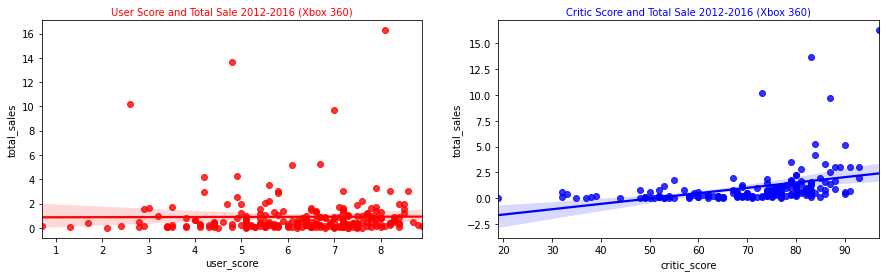

In [109]:
#regplot for both user_score and critic score
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))
sns.regplot(x="user_score", y="total_sales", data=x360, ax=axs[0], color='r')
sns.regplot(x="critic_score", y="total_sales", data=x360, ax=axs[1], color='b')
axs[0].set_title('User Score and Total Sale 2012-2016 (Xbox 360)', fontsize=10, color='r')
axs[1].set_title('Critic Score and Total Sale 2012-2016 (Xbox 360)', fontsize=10, color='b')
plt.show()

In [110]:
x360_corr = x360.pivot_table(index='total_sales', values=['user_score','critic_score']).reset_index()
x360_corr.corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.357285,-0.051431
critic_score,0.357285,1.000000,0.514005
user_score,-0.051431,0.514005,1.000000


Xbox critic score has a little correlation on total sales while user score doesn't. Which also visually see in the regression plot.

Compare the sales of the same games on other platforms.

In [111]:
selected_plat = filtered.query(' platform in ("PS2","PS3", "X360", "Wii", "DS", "PS4","GBA")')

In [112]:
other_plat = selected_plat.pivot_table(index='total_sales', values=['user_score','critic_score']).reset_index()
other_plat.tail()

,total_sales,critic_score,user_score
313,12.62,97.0,8.3
314,13.68,83.0,4.8
315,13.79,83.0,5.3
316,16.27,97.0,8.1
317,21.05,97.0,8.2


#regplot for both user_score and critic score
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))
sns.regplot(x="user_score", y="total_sales", data=other_plat, ax=axs[0], color='r')
sns.regplot(x="critic_score", y="total_sales", data=other_plat, ax=axs[1], color='b')
axs[0].set_title('User Score and Total Sale 2012-2016 (Top platforms)', fontsize=10, color='r')
axs[1].set_title('Critic Score and Total Sale 2012-2016 (Top platforms)', fontsize=10, color='b')
plt.show()

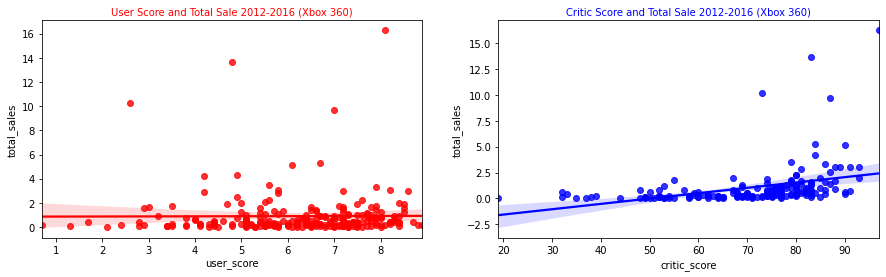

In [113]:
#regplot for both user_score and critic score per plat
fig, axs = plt.subplots(ncols=2, figsize=(15,4))
sns.regplot(x="user_score", y="total_sales", data=x360, ax=axs[0], color='r')
sns.regplot(x="critic_score", y="total_sales", data=x360, ax=axs[1], color='b')
axs[0].set_title('User Score and Total Sale 2012-2016 (Xbox 360)', fontsize=10, color='r')
axs[1].set_title('Critic Score and Total Sale 2012-2016 (Xbox 360)', fontsize=10, color='b')
plt.show()

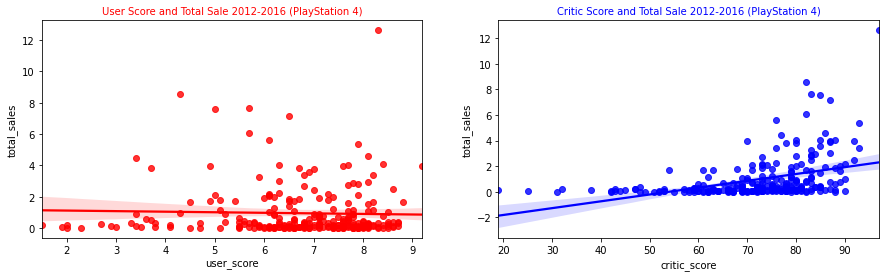

In [114]:
fig, axs = plt.subplots(ncols=2, figsize=(15,4))
sns.regplot(x="user_score", y="total_sales", data=PS4, ax=axs[0], color='r')
sns.regplot(x="critic_score", y="total_sales", data=PS4, ax=axs[1], color='b')
axs[0].set_title('User Score and Total Sale 2012-2016 (PlayStation 4)', fontsize=10, color='r')
axs[1].set_title('Critic Score and Total Sale 2012-2016 (PlayStation 4)', fontsize=10, color='b')
plt.show()

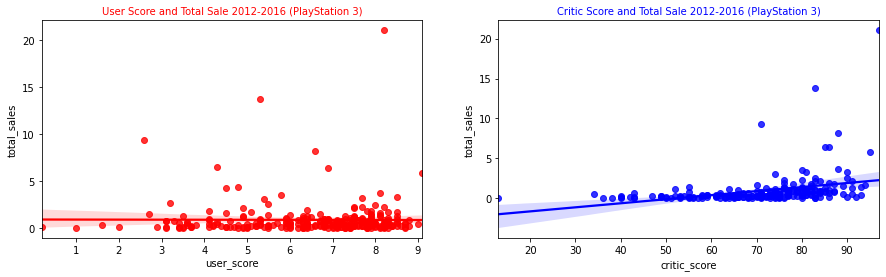

In [115]:
fig, axs = plt.subplots(ncols=2, figsize=(15,4))
sns.regplot(x="user_score", y="total_sales", data=PS3, ax=axs[0], color='r')
sns.regplot(x="critic_score", y="total_sales", data=PS3, ax=axs[1], color='b')
axs[0].set_title('User Score and Total Sale 2012-2016 (PlayStation 3)', fontsize=10, color='r')
axs[1].set_title('Critic Score and Total Sale 2012-2016 (PlayStation 3)', fontsize=10, color='b')
plt.show()

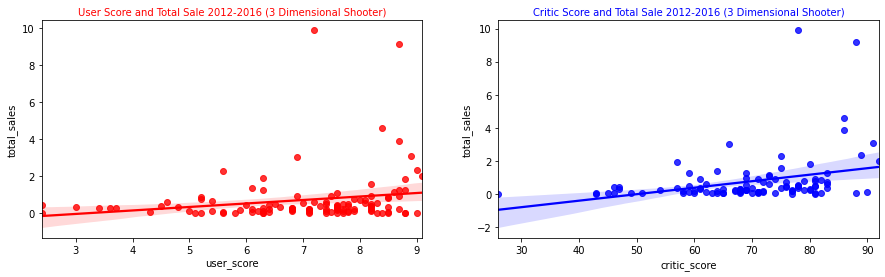

In [116]:
fig, axs = plt.subplots(ncols=2, figsize=(15,4))
sns.regplot(x="user_score", y="total_sales", data=DS3, ax=axs[0], color='r')
sns.regplot(x="critic_score", y="total_sales", data=DS3, ax=axs[1], color='b')
axs[0].set_title('User Score and Total Sale 2012-2016 (3 Dimensional Shooter)', fontsize=10, color='r')
axs[1].set_title('Critic Score and Total Sale 2012-2016 (3 Dimensional Shooter)', fontsize=10, color='b')
plt.show()

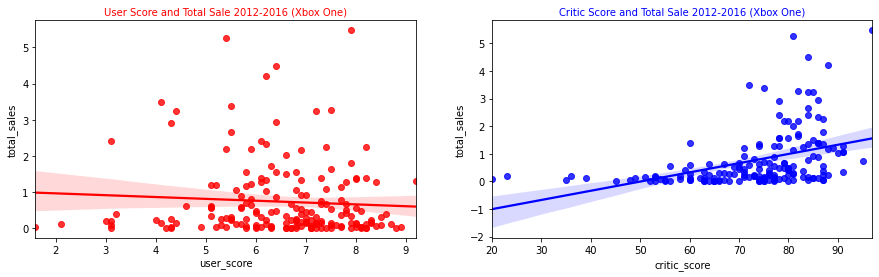

In [117]:
fig, axs = plt.subplots(ncols=2, figsize=(15,4))
sns.regplot(x="user_score", y="total_sales", data=XOne, ax=axs[0], color='r')
sns.regplot(x="critic_score", y="total_sales", data=XOne, ax=axs[1], color='b')
axs[0].set_title('User Score and Total Sale 2012-2016 (Xbox One)', fontsize=10, color='r')
axs[1].set_title('Critic Score and Total Sale 2012-2016 (Xbox One)', fontsize=10, color='b')
plt.show()

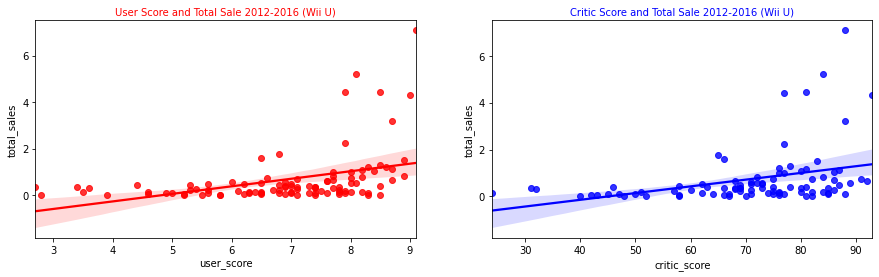

In [118]:
fig, axs = plt.subplots(ncols=2, figsize=(15,4))
sns.regplot(x="user_score", y="total_sales", data=WiiU, ax=axs[0], color='r')
sns.regplot(x="critic_score", y="total_sales", data=WiiU, ax=axs[1], color='b')
axs[0].set_title('User Score and Total Sale 2012-2016 (Wii U)', fontsize=10, color='r')
axs[1].set_title('Critic Score and Total Sale 2012-2016 (Wii U)', fontsize=10, color='b')
plt.show()

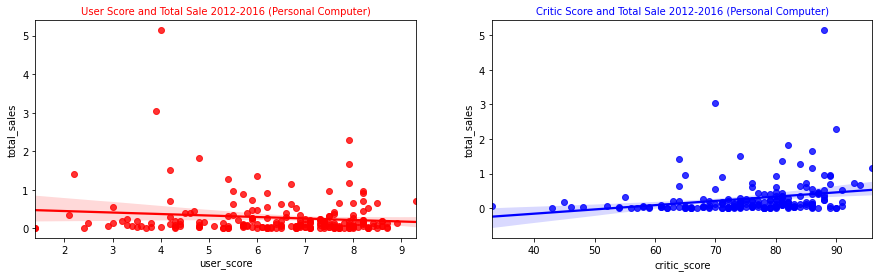

In [119]:
fig, axs = plt.subplots(ncols=2, figsize=(15,4))
sns.regplot(x="user_score", y="total_sales", data=PC, ax=axs[0], color='r')
sns.regplot(x="critic_score", y="total_sales", data=PC, ax=axs[1], color='b')
axs[0].set_title('User Score and Total Sale 2012-2016 (Personal Computer)', fontsize=10, color='r')
axs[1].set_title('Critic Score and Total Sale 2012-2016 (Personal Computer)', fontsize=10, color='b')
plt.show()

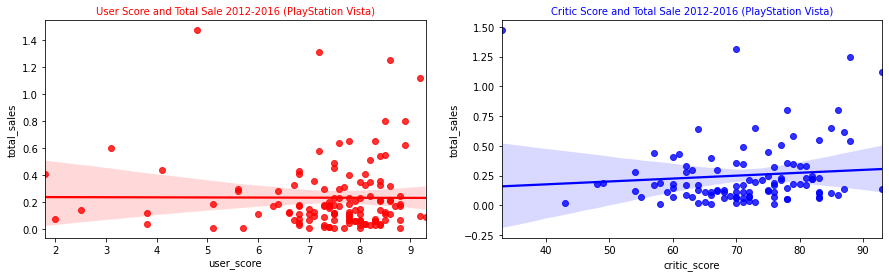

In [120]:
fig, axs = plt.subplots(ncols=2, figsize=(15,4))
sns.regplot(x="user_score", y="total_sales", data=PSV, ax=axs[0], color='r')
sns.regplot(x="critic_score", y="total_sales", data=PSV, ax=axs[1], color='b')
axs[0].set_title('User Score and Total Sale 2012-2016 (PlayStation Vista)', fontsize=10, color='r')
axs[1].set_title('Critic Score and Total Sale 2012-2016 (PlayStation Vista)', fontsize=10, color='b')
plt.show()

In [121]:
other_plat.corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.428491,-0.039291
critic_score,0.428491,1.000000,0.421308
user_score,-0.039291,0.421308,1.000000


After checking the popular platforms, It confirmed that the critic score does have a minor impact on total sales while the user score doesn't.

What can we say about the most profitable genres? Can you generalize about genres with high and low sales?

In [122]:
#filter only top 5 platform
Pop_plat = filtered.query(' platform in ("PS4","PS3", "X360", "3DS", "XOne")')

In [123]:
#create a pivot of total sale grouped by platform
genre_pivot = Pop_plat.pivot_table(index=['platform', 'genre'],
                                          values=['na_sales','eu_sales','jp_sales' ,'other_sales' ,'total_sales' ],
                                          aggfunc=sum).reset_index()\
.sort_values(by='total_sales', ascending=False)

In [124]:
#Plot barplot for Total sales in each genre by platform
fig = px.bar(genre_pivot, x="genre", y='total_sales', barmode='group',
             color='platform',
             title='Total sales in each genre by platform 2012-2016',
            labels=dict(total_sales='Total Sales', genre='Genre'),
             height=500)

fig.update_layout(barmode='stack')
fig.show()

According to the bar graph,

The five most popular genres are action, shooter, sports, Role-playing, and Racing.
Role-playing, Platform, and Simulation are very popular in 3DS, while Shooters and Racing don't.
Strategy and Puzzle are not popular in the top platform during 2012 - 2016.
PS4, Xbox360, PS3 got the sales from most of the game genres.

In [125]:
#create a pivot of total sale grouped by genre.
genre_comp = filtered.pivot_table(index=['genre'],
                                       values=['na_sales','eu_sales','jp_sales' ,'total_sales','other_sales' ],
                                       aggfunc=sum)\
.reset_index()\
.sort_values(by='total_sales', ascending=False)

genre_comp.sample(5)

,genre,eu_sales,jp_sales,na_sales,other_sales,total_sales
11,Strategy,5.17,2.88,4.23,1.06,13.34
2,Fighting,10.79,9.44,19.79,4.47,44.49
10,Sports,69.09,8.01,81.53,22.44,181.07
5,Puzzle,1.40,2.14,1.13,0.22,4.89
1,Adventure,9.46,8.24,8.92,2.81,29.43


In [126]:
#Barplot total sale in each platform by region
fig = px.bar(genre_comp, x="genre", y=['eu_sales','jp_sales', 'na_sales','other_sales'], barmode='group',
             title='Total sales in each platform by region 2012-2016',
            labels=dict(value='Total Sales', genre='Genre'),
             height=500)

fig.update_layout(barmode='stack')
fig.show()

In [127]:
#Boxplot total sale in each platform by region
fig = px.box(genre_comp, x="genre", y=['eu_sales','jp_sales', 'na_sales','other_sales'], points= 'all', 
             title='Total sales in each platform by region 2012-2016',
            labels=dict(value='Total Sales', genre='Genre'),
             height=500)

fig.update_layout(barmode='stack')
fig.show()

According to the bar graph,

North America and Europe have high share in most kind of genres.
The most popular genres are Action, Shooter, Role-playing, Sports and Misc.
Role Playing is very popular in japan, while shooters, sports and racing share a very low ratio.

In [128]:
fig = px.bar(genre_comp, x=['eu_sales','jp_sales', 'na_sales','other_sales'], y="genre", barmode='group',
             title='Total sales in each platform by region 2012-2016',
            labels=dict(value='Total Sales', genre='Genre'),
             height=500)

fig.update_layout(barmode='stack')
fig.show()

# Step 4

Describe variations in their market shares from region to region.

In [129]:
#pivot to total sale in each platform
region = filtered.pivot_table(index=['platform'],
                                      values =['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales'],
                                      aggfunc=sum)\
.reset_index().sort_values(by='total_sales', ascending=False)

#select only the top five in total sale
top_plat_region = region.head(5)
top_plat_region

,platform,eu_sales,jp_sales,na_sales,other_sales,total_sales
4,PS4,141.09,15.96,108.74,48.35,314.14
3,PS3,106.86,35.29,103.38,43.26,288.79
9,X360,74.52,1.57,140.05,20.40,236.54
0,3DS,42.64,87.79,55.31,8.87,194.61
10,XOne,51.59,0.34,93.12,14.27,159.32


In [130]:
#plot bar chart on region sale by each platform
fig = px.bar(top_plat_region, x="platform", y=['eu_sales','jp_sales', 'na_sales','other_sales'], barmode='group',
             title='Total sales in each platform by region 2012-2016',
            labels=dict(value='Total Sales', platform='Platform'),
             height=500)

fig.update_layout(barmode='stack')
fig.show()

PS4 is top in total sales in most of the regions except in Japan and North America.
X360 is the most popular in North America but got low sale from Japan.
3DS is very popular in Japan, meanwhile Xbox One got lowest sales in Japan.

In [131]:
#Plot piechart to see market share amoung platform in each regions

labels = top_plat_region['platform']

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=4, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=top_plat_region['eu_sales'], name="Europe Sale"),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=top_plat_region['jp_sales'], name="Japan Sale"),
              1, 2)
fig.add_trace(go.Pie(labels=labels, values=top_plat_region['na_sales'], name="North America Sale"),
              1, 3)
fig.add_trace(go.Pie(labels=labels,values=top_plat_region['other_sales'], name="Other Sale"),
              1, 4)


fig.update_layout(
    title_text="Market share in each region 2012-2016",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Europe Sale', x=0.02, y=0.9, font_size=20, showarrow=False),
                 dict(text='Japan Sale', x=0.36, y=0.9, font_size=20, showarrow=False),
                dict(text='North America Sale', x=0.76, y=0.9, font_size=20, showarrow=False),
                dict(text='Other Sale', x=0.97, y=0.9, font_size=20, showarrow=False)])
fig.show()

Europe has the highest share in PS4 with 33.9%, followed by PS3 at 25.6%, while 3DS is the lowest at 10.2%.
Japan has one leader, DS at 37%, followed by PS3 and PS4, while Xbox 360 and One are not popular.
In North America, most of the top platforms got a very similar ratio. The highest is Xbox360, followed by PS4 PS3 and Xbox, while 3DS is the lowest.
Other regions: the market winner is PS4 at 35.8%. Second place PS3 at 32%. The smallest share on DS at 6.6%.

In [132]:
#top 5 by region
genre = filtered.pivot_table(index=['genre'],
                                      values =['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales'],
                                      aggfunc=sum)\
.reset_index().sort_values(by='total_sales', ascending=False)

top_plat_genre = genre.head(5)
top_plat_genre

,genre,eu_sales,jp_sales,na_sales,other_sales,total_sales
0,Action,159.34,52.80,177.84,51.14,441.12
8,Shooter,113.47,9.23,144.77,37.26,304.73
7,Role-Playing,48.53,65.44,64.00,14.83,192.80
10,Sports,69.09,8.01,81.53,22.44,181.07
3,Misc,26.32,12.86,38.19,7.67,85.04


In [133]:
fig = px.bar(top_plat_genre, x="genre", y=['eu_sales','jp_sales', 'na_sales','other_sales'], barmode='group',
             title='Total sales in each genre by region 2012-2016',
            labels=dict(value='Total Sales', genre='Genre'),
             height=500)

fig.update_layout(barmode='stack')
fig.show()

Action is a leader in total sales I in the market, with the highest sale in North America and Europe.
Also Shooter, Sports are not popular in Japan but got the highest sale in role-playing.
Misc is not popular in most regions.

In [134]:
#Plot piechart to see market share amoung genre in each regions
labels = top_plat_genre['genre']

# Create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=4, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=labels, values=top_plat_region['eu_sales'], name="Europe Sale"),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=top_plat_region['jp_sales'], name="Japan Sale"),
              1, 2)
fig.add_trace(go.Pie(labels=labels, values=top_plat_region['na_sales'], name="North America Sale"),
              1, 3)
fig.add_trace(go.Pie(labels=labels,values=top_plat_region['other_sales'], name="Other Sale"),
              1, 4)


fig.update_layout(
    title_text="Market share in each region 2012-2016",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Europe Sale', x=0.02, y=0.9, font_size=20, showarrow=False),
                 dict(text='Japan Sale', x=0.36, y=0.9, font_size=20, showarrow=False),
                dict(text='North America Sale', x=0.76, y=0.9, font_size=20, showarrow=False),
                dict(text='Other Sale', x=0.97, y=0.9, font_size=20, showarrow=False)])
fig.show()


Europe: Action has the highest share with 33.9% and the lowest share on sports.
Japan: Sport has the highest share with 62.3%, while role-playing and misc are very low in this market.
Role-playing has the highest share in North America; others are slightly lower, with The lowest percentage on Sport at 11%.
Lastly, Other regions: the market winner is Action 35.8%. Second place Shooter 32%. and The less consumed platform is Sport at 6.56%.

Japanese market is different from other regions, with the highest sale in the 3DS platform and Role-playing games.
Even though the sport is not the main sale in Japan, it still has the highest market share compared with other regions.
Outside Japan, Xbox360, PS4, and PS3 are on most of the top lists. PS4 is the leader in Europe and other regions, while Xbox is in North America.

Do ESRB ratings affect sales in individual regions?

In [135]:
#pivot region sale in every ESRB rating
grouped_rating = filtered.pivot_table(index=['rating'],
                                      values =['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales'],
                                      aggfunc=sum)\
.reset_index()\
.sort_values(by='total_sales', ascending=False)

grouped_rating

,rating,eu_sales,jp_sales,na_sales,other_sales,total_sales
2,M,193.96,21.20,231.57,63.38,510.11
0,E,113.03,28.33,114.37,31.44,287.17
3,T,52.96,26.02,66.02,17.94,162.94
1,E10+,55.37,8.19,75.70,16.23,155.49


In [136]:
#plot bar chart of Total sales in each rating by region
fig = px.bar(grouped_rating, x="rating", y=['eu_sales','jp_sales', 'na_sales','other_sales'], barmode='group',
             title='Total sales in each rating by region 2012-2016',
            labels=dict(value='Total Sales', rating='Rating'),
             height=500)

fig.update_layout(barmode='stack')
fig.show()

The most market shared is M rating.
Japan is not a big fan of games with E10+ rating.
AO, EC, and RP are not popular so they are not even appear in chart.

# Step 5

Hypothesis 1: Average user ratings of the Xbox One and PC platforms are the same.

The Null hypothesis (H0) is that the average user ratings of the Xbox One and PC platforms belongs to the same statistical population.
The Alternative hypothesis (H1) is that the average user ratings of the Xbox One and PC platforms doesn't belong to the same statistical population.
The significance level be 0.05.

In [137]:
#Create 2 dataset user ratings for XOne and PC.
filtered_xbox = filtered.query('platform == "XOne"')
filtered_pc = filtered.query('platform == "PC"')

#Pivot by year of release and platform
user_rating_xbox = filtered_xbox.pivot_table(index=['year_of_release', 'platform'], values=['user_score']).reset_index()
user_rating_pc = filtered_pc.pivot_table(index=['year_of_release', 'platform'], values=['user_score']).reset_index()

#Average on each datasets
xbox_avg = user_rating_xbox['user_score']
pc_avg = user_rating_pc['user_score']

In [138]:
#Use Levene test tests the null hypothesis that all input samples are from populations with equal variances.
stat, p = levene(xbox_avg, pc_avg)
print("p-value from levene test: ", p.round(5))

p-value from levene test:  0.58117


In [139]:
alpha = 0.05 

#the p-value of the levene test is more than the threshold value of 0.05 , the sample groups have equal variance.
results = st.ttest_ind(
        xbox_avg, 
        pc_avg,
    equal_var=True)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 0.9615014863537478
We can't reject the null hypothesis


Hypothesis 2: Average user ratings for the Action and Sports genres are different.

The Null hypothesis (H0) : the average user ratings of the Action and Sports are belongs to the same statistical population.
The Alternative hypothesis (H1) : the average user ratings of the Action and Sports are not belongs to the same statistical population.
The significance level be 0.05.

In [140]:
filtered_action = filtered.query('genre == "Action"')
filtered_sports = filtered.query('genre == "Sports"')

user_rating_action = filtered_action.pivot_table(index=['year_of_release', 'genre'], values=['user_score']).reset_index()
user_rating_sports = filtered_sports.pivot_table(index=['year_of_release', 'genre'], values=['user_score']).reset_index()

action_avg = user_rating_action['user_score']
sports_avg = user_rating_sports['user_score']

In [141]:
#Use Levene test tests the null hypothesis that all input samples are from populations with equal variances.
stat, p = levene(action_avg, sports_avg )
print("p-value from levene test: ", p.round(5))

p-value from levene test:  0.44693


In [142]:
alpha = 0.05 

#the p-value of the levene test is more than the threshold value of 0.05 , the sample groups have equal variance.
results = st.ttest_ind(
        action_avg, 
        sports_avg,
    equal_var=True)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 0.0009719513539998414
We reject the null hypothesis


We can reject the Null hypothesis (H0), So the average user ratings of the Action and Sports aren't belongs to the same statistical population.

# Step 6

The goal of this project is to identify patterns that determine whether a game succeeds or not and spot potential big winners. After the analysis, Here are what I found:

The analysis showed that users from different areas prefer different genres. So marketing team should target marketing campaigns base on the region. Action, Shooters, and Sports are trendy in North America and Europe, While Japan market is focusing on Role-Playing.

There're also trend different in each platform. Must target PS4, PS3, and X360, which still have sale potential and popularity to increase sales in North America and Europe. While in Japan, we should focus on targeting on 3DS platform which is the most popular there.

As M (Mature) and E (Everyone) rating appears to be popular in most regions, it is better to advertise on these ratings if we want to increase the overall sales without concern about region preference.